# Problem Statement:

Acclaimed real estate firm House Sellers Plus has had a sudden change in leadership! Following a mid-life crisis executive director Jerry Seller has stepped down. Taking his place is his inexperienced son, Ben Seller. Ben has brought in a data science expert to provide the groundwork on evaluating the value of all the homes currently owned by the firm in Aimes, Iowa. 

Thankfully the Ames Assessor’s Office has provided to the firm a collection of data on the sale of houses in the area, which can be used to gain some insight into the housing market in the city.

This project will require the cleaning and use of the Ames housing data set in order to create models that can predict the sale price of a house. After cleaning the data I will use my newly acquired skills of modeling to attempt to find out what features predict the sale price of a house and build a model that can be used to do just that: predict the price of a house. 


# Background Research:

According to an article written for [Opendoor](https://www.opendoor.com/w/blog/factors-that-influence-home-value#:~:text=The%20local%20market,homes%20it's%20a%20seller's%20market.), a digital platform for buying and selling residential real estate,  two of the most essential factors affecting the price of a house are the overall home size, and the age of the house. Using the data and simple models I will look at how much those two factors hold true to predicting housing prices. I also plan to build a more complex model using much more of the data and other features noted in the article to try to build a more robust model. 

# imports

In [1]:
#standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.dummy import DummyRegressor

In [2]:
housing = pd.read_csv('./datasets/train.csv')
housingtest = pd.read_csv('./datasets/test.csv')

train_ids = housing['Id']
test_ids = housingtest['Id']

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

The data set is in generally pretty good shape, with 26 or so columns having nulls, but really only 6 or so that will need serious work. Without outlier(spoilers: there are outliers) I anticipate being able to keep most of the data.

# Cleaning Train Data:

In [4]:
nulls = housing.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
BsmtFin SF 2         1
Total Bsmt SF        1
BsmtFin SF 1         1
dtype: int64

There are a lot of data types that are categorical based on the scale: Excellent, Good, Typical, Fair, Poor. If the house didn't have the object of this category it was imputed as NA. an example of this would be for the fireplace quality category, if the house didn't have a category it was input as null values. Adjusting this to a number scale, excellent = 5, good = 4, typical = 3, fair = 2, poor = 1, and 0 for everything else. This will allows for the null values to be replaced with non-null zeros, and make the columns easier to work with as they will be in numbers and not strings. Thanks to [Kevin Crystal](https://medium.com/@kevin.a.crystal/intermediate-data-cleaning-195e1af3ccf9)'s blog post to help identify some patterns to clean and some code ideas to clean them.

In [5]:
# function to replace the ex - poor scale with numbers, replacing NA and nulls with zeros.
#also changes the column to a numeric column instead of a object column.
def scale_excellent(df, column_list):
    for column in column_list:
        df[column] = df[column].map({'Ex': 5,'Gd': 4, 'TA': 3,"Fa":2, 'Po': 1, 'NA':0})
        df[column] = pd.to_numeric(df[column])
        df[column] = df[column].fillna(0)

In [6]:
#columns to clean
cleaning_list = ['Bsmt Qual','Bsmt Cond','Exter Qual','Exter Cond','Fireplace Qu','Garage Qual', 
                'Garage Cond', 'Heating QC','Kitchen Qual', 'Pool QC']

In [7]:
scale_excellent(housing, cleaning_list)

A lot of the other null categories are also in rating scales, just not excellent to poor, this takes a bit more work but re-mapping all of them to be numerical will also deal with a large amount of the null values. 

In [8]:
#remaps a dictonary to a data frame, will make cleaing test data later easier to have this function.
def scale_other(column, reassign_dict, df): 
    df[column] = pd.to_numeric(df[column].map(reassign_dict))
    df[column] = df[column].fillna(0)

In [9]:
scale_excellent(housing, cleaning_list)
scale_other('Lot Shape', {'Reg':3,'IR1':2,'IR2': 1, 'IR3': 0}, housing)
scale_other('Utilities', {'AllPub':3,'NoSewr':2,'NoSeWa': 1, 'ELO': 0}, housing)
scale_other('Land Slope', {'Gtl':2,'Mod': 1, 'Sev': 0}, housing)
scale_other('Bsmt Exposure', {'GD': 4, 'Av':3,'Mn':2,'No': 1, 'NA': 0}, housing)
scale_other('BsmtFin Type 1', {'GLQ': 6 ,'ALQ':5,'BLQ':4, 'REC':3,'LWQ':2,'UNF': 1, 'NA': 0}, housing)
scale_other('BsmtFin Type 2', {'GLQ': 6 ,'ALQ':5,'BLQ':4, 'REC':3,'LWQ':2,'UNF': 1, 'NA': 0}, housing)
scale_other('Electrical', {'SBrKr': 4, 'FuseA':3,'FuseF':2,'FuseP': 1, 'NA': 0}, housing)
scale_other('Functional', {'Typ': 7, 'Min1': 6 ,'Min2':5,'Mod':4, 'Maj1':3,'Maj2':2,'Sev': 1, 'NA': 0}, housing)
scale_other('Garage Finish', {'Fin':3,'Rfn':2,'Unf': 1,}, housing)
scale_other('Paved Drive', {'Y':2,'P': 1, 'N': 0}, housing)
scale_other('Fence', {'GdPrv': 4, 'MnPrv':3,'GdWo':2,'MnWw': 1, 'NA': 0}, housing)

In [10]:
nulls = housing.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Misc Feature      1986
Alley             1911
Lot Frontage       330
Garage Yr Blt      114
Garage Type        113
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
BsmtFin SF 1         1
Garage Cars          1
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
dtype: int64

There are only 2051 data points, so having over 1900 data points be null seems like those columns cant be saved. filling in 71% of that data with the mean or with a zero value will have large adverse effects on the model, so I will remove these two columns. I am also removing the PID column because it is just an extra identification number, which I don't want interacting with in my models. 

In [11]:
housing.drop(columns=['Misc Feature', 'Alley','PID'], inplace=True)

In [12]:
nulls = housing.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Lot Frontage      330
Garage Yr Blt     114
Garage Type       113
Mas Vnr Area       22
Mas Vnr Type       22
Bsmt Full Bath      2
Bsmt Half Bath      2
BsmtFin SF 1        1
Garage Cars         1
Garage Area         1
BsmtFin SF 2        1
Total Bsmt SF       1
Bsmt Unf SF         1
dtype: int64

looking at the garage data to look and see what type of data I should fill in. The plan is to build a small data frame to look and see if peopless garages were built the year they remodeled or the year their house was built to decide what value to impute with.

In [13]:
garageinfo = housing[['Garage Yr Blt', 'Year Built', 'Year Remod/Add']].copy()

In [14]:
garageinfo.head()

,Garage Yr Blt,Year Built,Year Remod/Add
0,1976.0,1976,2005
1,1997.0,1996,1997
2,1953.0,1953,2007
3,2007.0,2006,2007
4,1957.0,1900,1993


In [15]:
garageinfo['Garage built'] = garageinfo['Garage Yr Blt'] - garageinfo['Year Built']

In [16]:
garageinfo['Garage built'].map(lambda x: True if x == 0 else False).value_counts()
#true if the garage was built in the same year as the house. 

True     1564
False     487
Name: Garage built, dtype: int64

We see mostly true values, which means in most of the cases the garage was built in the same year as the house, so I will impute with the same value as the year the house was built. 

In [17]:
housing['Garage Yr Blt'].fillna(value=housing['Year Built'], inplace=True)

In [18]:
nulls = housing.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Lot Frontage      330
Garage Type       113
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Half Bath      2
Bsmt Full Bath      2
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
BsmtFin SF 1        1
Garage Cars         1
Garage Area         1
dtype: int64

for the rest of these data types, I will go through the value counts and determine if they would be better served imputed by the mean or the mode. If there is a good spread of the data (and it's not categorical) I will use the mean, if the data is very skewed towards one answer I will impute the mode into the columns. 

In [19]:
nulls = housing.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Lot Frontage      330
Garage Type       113
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Half Bath      2
Bsmt Full Bath      2
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
BsmtFin SF 1        1
Garage Cars         1
Garage Area         1
dtype: int64

In [20]:
#list to store which of the remaining variables will get which type of imputation. 
mean_list = [] 
mode_list_string = []
mode_list_int = []

In [21]:
housing['Lot Frontage'].sort_values()

53      21.0
1534    21.0
787     21.0
796     21.0
1834    21.0
        ... 
2016     NaN
2022     NaN
2028     NaN
2031     NaN
2047     NaN
Name: Lot Frontage, Length: 2051, dtype: float64

In [22]:
housing['Lot Frontage'].value_counts()

60.0     179
70.0      96
80.0      94
50.0      90
65.0      71
        ... 
22.0       1
155.0      1
153.0      1
119.0      1
135.0      1
Name: Lot Frontage, Length: 118, dtype: int64

Use the mean for lot frontage.

In [23]:
mean_list.append('Lot Frontage')

In [24]:
housing['Garage Type'].value_counts() #mode

Attchd     1213
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64

Use the mode for garage type, most are Attached style.

In [25]:
mode_list_string.append('Garage Type')

In [26]:
housing['Mas Vnr Area'].value_counts() #mode

0.0      1216
120.0      11
176.0      10
200.0      10
180.0       9
         ... 
57.0        1
572.0       1
65.0        1
567.0       1
161.0       1
Name: Mas Vnr Area, Length: 373, dtype: int64

Use the mode for veneered area.

In [27]:
mode_list_int.append('Mas Vnr Area')

In [28]:
housing['Mas Vnr Type'].value_counts() #mode

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

Use the mode for veneer type.

In [29]:
mode_list_string.append('Mas Vnr Type')

In [30]:
housing['Bsmt Half Bath'].value_counts() #mode

0.0    1923
1.0     122
2.0       4
Name: Bsmt Half Bath, dtype: int64

Use the mode for the count of half bathrooms in the basement.

In [31]:
mode_list_int.append('Bsmt Half Bath')

In [32]:
housing['Bsmt Full Bath'].value_counts() #mean

0.0    1200
1.0     824
2.0      23
3.0       2
Name: Bsmt Full Bath, dtype: int64

Use the mean for the full bathroom count in the basement

In [33]:
mean_list.append('Bsmt Full Bath')

In [34]:
housing['BsmtFin SF 2'].value_counts() #mode

0.0      1803
294.0       5
162.0       3
539.0       3
72.0        3
         ... 
712.0       1
529.0       1
215.0       1
252.0       1
823.0       1
Name: BsmtFin SF 2, Length: 205, dtype: int64

Use the mode for the square footage of the finished basement.

In [35]:
mode_list_int.append('BsmtFin SF 2')

In [36]:
housing['Bsmt Unf SF'].value_counts() #mean

0.0       165
384.0      14
672.0      11
728.0      10
816.0       9
         ... 
494.0       1
1323.0      1
1041.0      1
314.0       1
2062.0      1
Name: Bsmt Unf SF, Length: 967, dtype: int64

Use the mean for unfinshed square footage in the basement.

In [37]:
mean_list.append('Bsmt Unf SF')

In [38]:
housing['Total Bsmt SF'].value_counts() # mean

0.0       54
864.0     51
672.0     20
1040.0    20
816.0     17
          ..
842.0      1
752.0      1
1232.0     1
1480.0     1
1125.0     1
Name: Total Bsmt SF, Length: 892, dtype: int64

Use the mean for the total basemente square footage.

In [39]:
mean_list.append('Total Bsmt SF')

In [40]:
housing['BsmtFin SF 1'].value_counts() # mean

0.0      657
24.0      17
16.0      10
300.0      7
384.0      7
        ... 
848.0      1
70.0       1
688.0      1
472.0      1
661.0      1
Name: BsmtFin SF 1, Length: 821, dtype: int64

Use the mean for the square footage of the finished basement 1.

In [41]:
mean_list.append('BsmtFin SF 1')

In [42]:
housing['Garage Cars'].value_counts() # mean

2.0    1136
1.0     524
3.0     263
0.0     113
4.0      13
5.0       1
Name: Garage Cars, dtype: int64

Use the mean for the number of cars the garage can hold.

In [43]:
mean_list.append('Garage Cars')

In [44]:
housing['Garage Area'].value_counts() #mean

0.0       113
440.0      70
576.0      69
484.0      52
528.0      46
         ... 
406.0       1
309.0       1
580.0       1
1184.0      1
557.0       1
Name: Garage Area, Length: 514, dtype: int64

Use the mean for the area of the garage.

In [45]:
mean_list.append('Garage Area')

In [46]:
#used to replace the nulls with the mean of a column.
def replace_mean(df, column_list):
    for column in column_list:
        df[column].fillna(df[column].mean(), inplace=True)

In [47]:
#used to replace the nulls with the mode if it is a numeric value
def replace_mode(df, column_list):
    for column in column_list:
        df[column].fillna(int(df[column].mode()), inplace=True)

In [48]:
replace_mean(housing, mean_list)

In [49]:
replace_mode(housing, mode_list_int)

Fill in the non-numeric mode nulls nulls.

In [50]:
mode_list_string

['Garage Type', 'Mas Vnr Type']

In [51]:
housing['Garage Type'].fillna('Attchd', inplace=True)

In [52]:
housing['Mas Vnr Type'].fillna('None', inplace=True)

In [53]:
nulls = housing.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Series([], dtype: int64)

All the nulls are finally delt with, now just need to deal with other outliers spotted in EDA

In [54]:
housing['Garage Yr Blt'].sort_values()

951     1872.0
136     1875.0
1204    1890.0
457     1895.0
1793    1895.0
         ...  
1671    2009.0
625     2009.0
144     2010.0
1241    2010.0
1699    2207.0
Name: Garage Yr Blt, Length: 2051, dtype: float64

A house appears to have been built in 2207, lets take a look at the row

In [55]:
housing.loc[1699, ["Garage Yr Blt", 'Year Remod/Add']]

Garage Yr Blt     2207
Year Remod/Add    2007
Name: 1699, dtype: object

Assumed as a clerical error, should be 2007 not 2207.

In [56]:
housing.at[1699, 'Garage Yr Blt'] = 2007

In [57]:
housing.loc[1699, ["Garage Yr Blt", 'Year Remod/Add']]

Garage Yr Blt     2007
Year Remod/Add    2007
Name: 1699, dtype: object

Removing the outliers warned about in the data dictionary. 

In [58]:
housing['Gr Liv Area']= housing['Gr Liv Area'].map(lambda x: np.nan if x >4000 else x)
housing.dropna(inplace=True)

In [59]:
housing['Lot Area']= housing['Lot Area'].map(lambda x: np.nan if x >7000 else x)
housing.dropna(inplace=True)

In [60]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,410.0,1477.185366,854.518612,8.0,740.50,1497.5,2231.25,2920.0
MS SubClass,410.0,94.987805,53.852214,20.0,50.00,120.0,160.00,190.0
Lot Frontage,410.0,48.622997,17.182752,21.0,35.00,50.0,60.00,153.0
Lot Area,410.0,4635.260976,1670.354178,1300.0,3185.50,4980.0,6060.00,7000.0
Lot Shape,410.0,2.790244,0.453082,0.0,3.00,3.0,3.00,3.0
Utilities,410.0,3.000000,0.000000,3.0,3.00,3.0,3.00,3.0
Land Slope,410.0,1.948780,0.231527,0.0,2.00,2.0,2.00,2.0
Overall Qual,410.0,5.939024,1.322622,1.0,5.00,6.0,7.00,10.0
Overall Cond,410.0,5.678049,1.171694,1.0,5.00,5.0,6.00,9.0
Year Built,410.0,1964.621951,33.272396,1872.0,1935.00,1971.0,2000.00,2009.0


Double checking for weird or strange min, max, average values, it looks good! lets clean the test data to be in the same state!

# cleaning test data

In [61]:
nulls = housingtest.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Pool QC           874
Misc Feature      837
Alley             820
Fence             706
Fireplace Qu      422
Lot Frontage      160
Garage Cond        45
Garage Qual        45
Garage Yr Blt      45
Garage Finish      45
Garage Type        44
Bsmt Exposure      25
BsmtFin Type 1     25
Bsmt Qual          25
BsmtFin Type 2     25
Bsmt Cond          25
Mas Vnr Area        1
Mas Vnr Type        1
Electrical          1
dtype: int64

test data will have the same kind of nulls as the training data. Running it through all the same functions and commands will solve any issues. note: do not have to drop outliers in test data as we do no know if they are there and dont want to modify the Y values of the test data.

In [62]:
scale_excellent(housingtest, cleaning_list)
scale_other('Lot Shape', {'Reg':3,'IR1':2,'IR2': 1, 'IR3': 0}, housingtest)
scale_other('Utilities', {'AllPub':3,'NoSewr':2,'NoSeWa': 1, 'ELO': 0}, housingtest)
scale_other('Land Slope', {'Gtl':2,'Mod': 1, 'Sev': 0}, housingtest)
scale_other('Bsmt Exposure', {'GD': 4, 'Av':3,'Mn':2,'No': 1, 'NA': 0}, housingtest)
scale_other('BsmtFin Type 1', {'GLQ': 6 ,'ALQ':5,'BLQ':4, 'REC':3,'LWQ':2,'UNF': 1, 'NA': 0}, housingtest)
scale_other('BsmtFin Type 2', {'GLQ': 6 ,'ALQ':5,'BLQ':4, 'REC':3,'LWQ':2,'UNF': 1, 'NA': 0}, housingtest)
scale_other('Electrical', {'SBrKr': 4, 'FuseA':3,'FuseF':2,'FuseP': 1, 'NA': 0}, housingtest)
scale_other('Functional', {'Typ': 7, 'Min1': 6 ,'Min2':5,'Mod':4, 'Maj1':3,'Maj2':2,'Sev': 1, 'NA': 0}, housing)
scale_other('Garage Finish', {'Fin':3,'Rfn':2,'Unf': 1,}, housingtest)
scale_other('Paved Drive', {'Y':2,'P': 1, 'N': 0}, housingtest)
scale_other('Fence', {'GdPrv': 4, 'MnPrv':3,'GdWo':2,'MnWw': 1, 'NA': 0}, housingtest)
housingtest.drop(columns=['Misc Feature', 'Alley', 'PID'], inplace=True)
housingtest['Garage Yr Blt'].fillna(value=housingtest['Year Built'], inplace=True)
replace_mean(housingtest, mean_list)
replace_mode(housingtest, mode_list_int)
housingtest['Garage Type'].fillna('Attchd', inplace=True)
housingtest['Mas Vnr Type'].fillna('None', inplace=True)


In [63]:
housingtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 77 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   MS SubClass      878 non-null    int64  
 2   MS Zoning        878 non-null    object 
 3   Lot Frontage     878 non-null    float64
 4   Lot Area         878 non-null    int64  
 5   Street           878 non-null    object 
 6   Lot Shape        878 non-null    int64  
 7   Land Contour     878 non-null    object 
 8   Utilities        878 non-null    int64  
 9   Lot Config       878 non-null    object 
 10  Land Slope       878 non-null    int64  
 11  Neighborhood     878 non-null    object 
 12  Condition 1      878 non-null    object 
 13  Condition 2      878 non-null    object 
 14  Bldg Type        878 non-null    object 
 15  House Style      878 non-null    object 
 16  Overall Qual     878 non-null    int64  
 17  Overall Cond    

In [64]:
nulls = housingtest.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Series([], dtype: int64)

Test data also appears to be cleaned. 

# feature engineering

For the modeling process I only want to use features that have correlation scores higher than 0.3. With so many features that have a risk of being co-linear, .3 seems like a good starting point to me to be able to pin down features of the data set that can most greatly impact my model. In this feature engineering section I will pull out the features that have that correlation and then check the type of column they are. In order to avoid having a crazy amount of dummied columns and having to relate them to their relative dropped columns, there will be a lot of binning to make these categories more approachable. 

In [65]:
 #accepts input of a data frame and returns a list of column names
# who have correlations above or below the specified amount.
def check_correlation(df, percent, target, dummied = False):
    if dummied:
        df = pd.get_dummies(df, drop_first=True)
    corr = df.corr()
    highcorr = corr[(corr[target] > percent) | (corr[target] < (-1*percent))]
    output = list(highcorr.index)
    output.remove(target)
    return output

In [66]:
thirty_corr = check_correlation(housing,.3, 'SalePrice')

In [67]:
thirty_corr

['Lot Shape',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Paved Drive']

In [68]:
thirty_corr_dumm =check_correlation(housing,.3, 'SalePrice', dummied=True)

In [69]:
thirty_corr_dumm

['Lot Shape',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Paved Drive',
 'MS Zoning_FV',
 'MS Zoning_RM',
 'Neighborhood_Somerst',
 'Bldg Type_TwnhsE',
 'House Style_1Story',
 'Mas Vnr Type_None',
 'Mas Vnr Type_Stone',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Central Air_Y',
 'Garage Type_Attchd',
 'Sale Type_New']

## binning

I am going to bin a lot of the dummied variables based on how well they were correlated. The dummied variables that I want to use appear to be neighborhood, Exterior, Masonry veneer type, foundation type, garage type, and sale type.

In [70]:
housing['Neighborhood'].value_counts()

OldTown    62
BrkSide    53
Somerst    47
Edwards    25
MeadowV    24
Blmngtn    22
IDOTRR     21
BrDale     19
SWISU      18
NridgHt    17
NPkVill    17
StoneBr    16
Crawfor    15
NAmes      11
CollgCr    11
Mitchel     8
Sawyer      8
Blueste     6
Timber      3
ClearCr     3
Greens      3
Landmrk     1
Name: Neighborhood, dtype: int64

In [71]:
housing.groupby('Neighborhood')['SalePrice'].mean().sort_values()

Neighborhood
MeadowV    100231.250000
BrDale     103371.052632
IDOTRR     107330.952381
OldTown    108577.161290
Edwards    118940.000000
BrkSide    118950.943396
SWISU      123071.333333
Sawyer     124781.250000
NAmes      133909.090909
Landmrk    137000.000000
NPkVill    140476.470588
Blueste    144566.666667
Mitchel    145812.500000
ClearCr    150466.666667
CollgCr    157677.272727
Greens     188666.666667
Somerst    190270.106383
Blmngtn    200417.681818
NridgHt    208975.882353
Crawfor    210570.933333
StoneBr    212437.500000
Timber     214000.000000
Name: SalePrice, dtype: float64

Gonna make some bins for the price of neighborhoods. 3 if price above 300k, 2 if between 200k and 300k, 1 if between 100k and 200k.

In [72]:
 neighborhoods_dict = {
     'MeadowV': 1, "IDOTRR": 1, "BrDale": 1, 'OldTown': 1, 'BrkSide': 1, 'Edwards': 1, 'SWISU': 1,
     'Landmrk': 1, 'Sawyer': 1, 'NPkVill': 1, 'Blueste': 1, 'NAmes': 1, 'Mitchel': 1, 'SawyerW': 1,
     'Greens' : 1, 'Gilbert': 1, 'NWAmes': 1, 'Blmngtn': 2, 'CollgCr': 2, 'Crawfor': 2, 'ClearCr': 2,
     'Somerst': 2, 'Timber' : 2, 'Veenker' : 2, "GrnHill": 2, 'NoRidge': 3, 'NridgHt': 3, 'StoneBr':3
 }

In [73]:
housing['Neighborhood'] = housing['Neighborhood'].map(neighborhoods_dict)

In [74]:
housing.groupby('Neighborhood')['SalePrice'].mean().sort_values()

Neighborhood
1    117553.507246
2    191468.297030
3    210654.242424
Name: SalePrice, dtype: float64

In the next section I will look at a lot of categorical variables, and just group all the small values into a category such as 'other' just to give the column a little bit more clarity.

In [75]:
housing['Exterior 1st'].value_counts(normalize=True)

MetalSd    0.253659
VinylSd    0.241463
Wd Sdng    0.173171
HdBoard    0.100000
CemntBd    0.097561
Plywood    0.051220
AsbShng    0.029268
WdShing    0.021951
Stucco     0.017073
BrkFace    0.012195
CBlock     0.002439
Name: Exterior 1st, dtype: float64

In [76]:
housing['Exterior 1st'] = housing['Exterior 1st'].map(lambda x: 'other' if x in ['BrkComm', 'CBlock', 'Stone', 'AsphShn', 'ImStucc'] else x)          

In [77]:
housing['Exterior 1st'].value_counts(normalize=True)

MetalSd    0.253659
VinylSd    0.241463
Wd Sdng    0.173171
HdBoard    0.100000
CemntBd    0.097561
Plywood    0.051220
AsbShng    0.029268
WdShing    0.021951
Stucco     0.017073
BrkFace    0.012195
other      0.002439
Name: Exterior 1st, dtype: float64

In [78]:
housing['Exterior 2nd'].value_counts(normalize=True)

MetalSd    0.248780
VinylSd    0.229268
Wd Sdng    0.151220
CmentBd    0.097561
HdBoard    0.082927
Wd Shng    0.053659
Plywood    0.046341
Brk Cmn    0.034146
AsbShng    0.021951
Stucco     0.019512
ImStucc    0.004878
BrkFace    0.004878
CBlock     0.004878
Name: Exterior 2nd, dtype: float64

In [79]:
housing['Exterior 2nd'] = housing['Exterior 2nd'].map(lambda x: 'other' if x in ['Brk Cmn', 'Stone', 'CBlock', 'AsphShn', 'ImStucc'] else x)          

In [80]:
housing['Exterior 2nd'].value_counts(normalize=True)

MetalSd    0.248780
VinylSd    0.229268
Wd Sdng    0.151220
CmentBd    0.097561
HdBoard    0.082927
Wd Shng    0.053659
Plywood    0.046341
other      0.043902
AsbShng    0.021951
Stucco     0.019512
BrkFace    0.004878
Name: Exterior 2nd, dtype: float64

In [81]:
housing['Mas Vnr Type'].value_counts(normalize=True)

None       0.700000
BrkFace    0.219512
Stone      0.078049
BrkCmn     0.002439
Name: Mas Vnr Type, dtype: float64

In [82]:
housing['Mas Vnr Type'] = housing['Mas Vnr Type'].map(lambda x: x if x in ['None', 'BrkFace'] else 'other')

In [83]:
housing['Mas Vnr Type'].value_counts(normalize=True)

None       0.700000
BrkFace    0.219512
other      0.080488
Name: Mas Vnr Type, dtype: float64

In [84]:
housing['Garage Type'].value_counts(normalize=True)

Attchd     0.495122
Detchd     0.446341
BuiltIn    0.034146
Basment    0.017073
CarPort    0.004878
2Types     0.002439
Name: Garage Type, dtype: float64

In [85]:
housing['Garage Type'] = housing['Garage Type'].map(lambda x: 'other' if x in ['CarPort', '2Types'] else x)  

In [86]:
housing['Garage Type'].value_counts(normalize=True)

Attchd     0.495122
Detchd     0.446341
BuiltIn    0.034146
Basment    0.017073
other      0.007317
Name: Garage Type, dtype: float64

In [87]:
housing['Sale Type'].value_counts()

WD       368
New       23
COD       11
ConLD      5
CWD        2
ConLI      1
Name: Sale Type, dtype: int64

In [88]:
housing['Sale Type'] = housing['Sale Type'].map(lambda x: 1 if x == 'WD ' else 0)

In [89]:
housing['Sale Type'].value_counts(normalize=True)

1    0.897561
0    0.102439
Name: Sale Type, dtype: float64

In [90]:
housing['Foundation'].value_counts(normalize=True)

PConc     0.421951
CBlock    0.363415
BrkTil    0.200000
Slab      0.007317
Stone     0.004878
Wood      0.002439
Name: Foundation, dtype: float64

In [91]:
housing['Foundation'] = housing['Foundation'].map(lambda x: 'other' if x in ['Slab', 'Stone', 'Wood'] else x)  

In [92]:
housing['Foundation'].value_counts(normalize=True)

PConc     0.421951
CBlock    0.363415
BrkTil    0.200000
other     0.014634
Name: Foundation, dtype: float64

## Creating a few extra columns:

 Creating a total square foot column:

In [93]:
housing['total_sf'] = housing['Gr Liv Area'] + housing['Total Bsmt SF']


Adding a recently built feature:

In [94]:
housing['recently built'] = (housing['Year Built'] > 2000).astype(int)

redefining our variable list, so we can use them when modeling later on.

In [95]:
thirty_corr = check_correlation(housing, .3, 'SalePrice')

In [96]:
thirty_corr

['Lot Shape',
 'Neighborhood',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Paved Drive',
 'total_sf',
 'recently built']

In [97]:
thirty_corr_dumm =check_correlation(housing,.3, 'SalePrice', dummied=True)

In [98]:
thirty_corr_dumm

['Lot Shape',
 'Neighborhood',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Paved Drive',
 'total_sf',
 'recently built',
 'MS Zoning_FV',
 'MS Zoning_RM',
 'Bldg Type_TwnhsE',
 'House Style_1Story',
 'Mas Vnr Type_None',
 'Mas Vnr Type_other',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Central Air_Y']

# feature engineering matching on test data

In [99]:
# bins
housingtest['Neighborhood'] = housingtest['Neighborhood'].map(neighborhoods_dict)
housingtest['Exterior 1st'] = housingtest['Exterior 1st'].map(lambda x: 'other' if x in ['BrkComm', 'CBlock', 'Stone', 'AsphShn', 'ImStucc'] else x)
housingtest['Exterior 2nd'] = housingtest['Exterior 2nd'].map(lambda x: 'other' if x in ['Brk Cmn', 'Stone', 'CBlock', 'AsphShn', 'ImStucc'] else x)
housingtest['Mas Vnr Type'] = housingtest['Mas Vnr Type'].map(lambda x: x if x in ['None', 'BrkFace'] else 'Other')
housingtest['Garage Type'] = housingtest['Garage Type'].map(lambda x: 'other' if x in ['CarPort', '2Types'] else x)  
housingtest['Sale Type'] = housingtest['Sale Type'].map(lambda x: 1 if x == 'WD ' else 0)
housingtest['Foundation'] = housingtest['Foundation'].map(lambda x: 'other' if x in ['Slab', 'Stone', 'Wood'] else x)  
# adding total square footage column
housingtest['total_sf'] = housingtest['Gr Liv Area'] + housingtest['Total Bsmt SF']
# recently built column
housingtest['recently built'] = (housingtest['Year Built'] > 2000).astype(int)



Using all the same transformations on the test data to make sure it is consistent. 

# EDA 

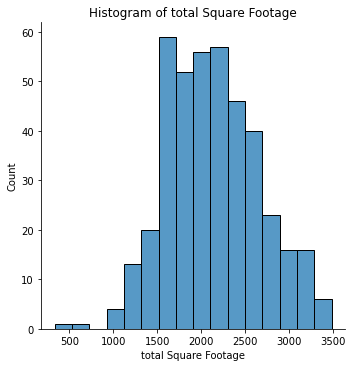

In [100]:
sns.displot(housing['total_sf'])
plt.title("Histogram of total Square Footage")
plt.xlabel('total Square Footage');

In this histogram we can see what I believe to be one of the key predictors, the total square footage of the house. This data is pretty close to normal, although there seems to be a pretty big platuea on top, pulling it away from normal.

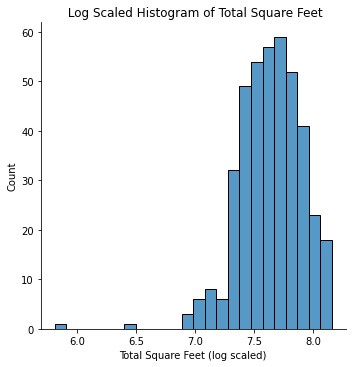

In [101]:
sns.displot(np.log(housing['total_sf']))
plt.title(" Log Scaled Histogram of Total Square Feet")
plt.xlabel('Total Square Feet (log scaled)');

Log scaling this data didnt seem to provide very much impact on the normalcy of it, but shows the effect of a few especially low outliers on the data. 

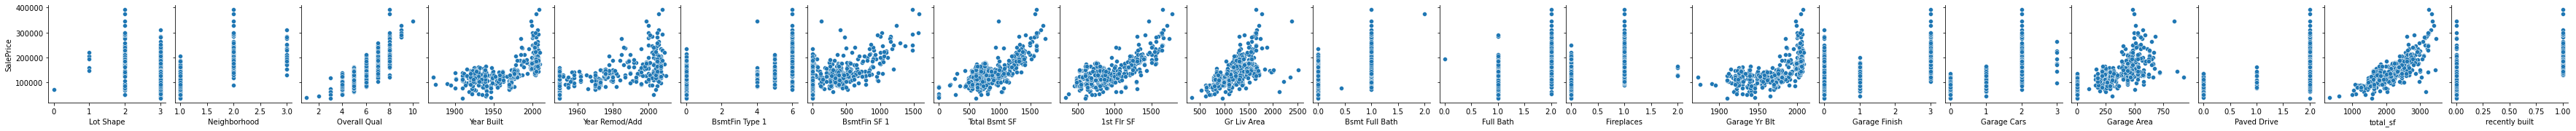

In [102]:
sns.pairplot(data= housing,
            y_vars= 'SalePrice',
            x_vars= thirty_corr,
            diag_kind = None);

models will likely see a lot of success using features that are mostly linear and have a good linear relationship with sale price. The year built, overall quality, year remodeled and most of the square footage measurements all seem to be good fits. 

<Figure size 864x720 with 0 Axes>

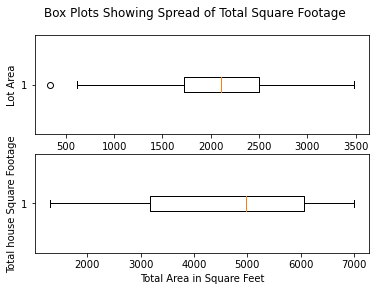

In [103]:
plt.figure(figsize=(12,10))

fig, axs = plt.subplots(2)
fig.suptitle("Box Plots Showing Spread of Total Square Footage ")
axs[0].boxplot(housing['total_sf'], vert=False)
axs[1].boxplot(housing['Lot Area'], vert=False)
axs[1].set_xlabel("Total Area in Square Feet")
axs[1].set_ylabel("Total house Square Footage")
axs[0].set_ylabel("Lot Area")
axs[1].set = ("ACT Composite Score");

These box plots show the spread of the lot area and the total square footage, these box plots helped in the identifying of outliers that were removed in EDA.

creating dummied data frames for use in models:

In [104]:
housing_dummied = pd.get_dummies(housing, drop_first=True)
housingtest_dummied = pd.get_dummies(housingtest, drop_first=True)

In [105]:
sns.set_style('darkgrid')

## DUMMY MODEL

In [106]:
X = housing.drop(columns = 'SalePrice')
y = housing['SalePrice']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12)

In [108]:
dummy_model = DummyRegressor()

In [109]:
dummy_model.fit(X_train,y_train)

DummyRegressor()

In [110]:
r2_score(y_train, dummy_model.predict(y_train)), r2_score(y_test, dummy_model.predict(y_test))

(0.0, -0.0003123229343455769)

In [111]:
mean_squared_error(y_train, dummy_model.predict(y_train), squared=False), mean_squared_error(y_test, dummy_model.predict(y_test), squared=False)

(49863.30691961956, 59691.474849518)

The dummy model just using the mean for the data has very very low R2 scores, and RMSE scores around 50,000 dollars. These will be the baseline numbers to compare our models too.  

## some simple more intereptable models to answer problem statement:

single linear regression using the total square footage. 

In [112]:
X = housing[['total_sf']]
y = housing['SalePrice']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 12)

In [114]:
basic_regression = LinearRegression()

In [115]:
cross_val_score(basic_regression,X_train,y_train).mean()

0.6332712484778161

In [116]:
basic_regression.fit(X_train,y_train)

LinearRegression()

In [117]:
basic_regression.score(X_train,y_train), basic_regression.score(X_test,y_test)

(0.6501316400668001, 0.5481076343828685)

this is definitely an overfitted model with significantly better performance on the train data than on the test data.

In [118]:
charting_preds = basic_regression.predict(X)

In [119]:
internal_testpreds_totalsf = basic_regression.predict(X_test)

In [120]:
mean_squared_error(y_test,internal_testpreds_totalsf, squared=False)

40120.099571750616

A pretty approachable mean squared error, its not great but it definitely out performs the dummy model. With our weaker R2 scores from before the model definitely has some limitation, but does show that there can be some predictive value with a linear regression. 

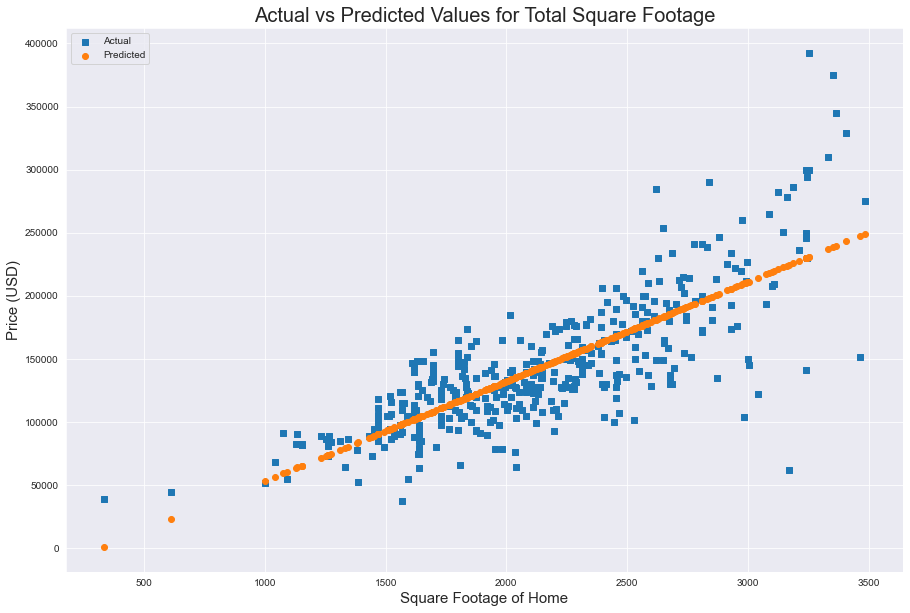

In [121]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)

ax1.scatter(housing['total_sf'], housing_dummied['SalePrice'],  marker="s", label='Actual')
ax1.scatter(housing['total_sf'], charting_preds,  marker="o", label='Predicted')
plt.legend(loc='upper left')
plt.title("Actual vs Predicted Values for Total Square Footage", size = 20)
plt.xlabel("Square Footage of Home", size = 15)
plt.ylabel('Price (USD)', size = 15);
plt.show()

This graph shows the actual values of sale price and the predicted values of sale price for the train data. It shows that there is some correlation between a homes square footage and with its sale price, with that linear relationship getting harder to predict as houses get bigger. 

In [122]:
print(basic_regression.coef_)

[78.80586709]


This coefficient of 80.8 shows the amount of increase in price based on increase in square footage. The assumptions we need to make to trust this value are not very strong, as with an RMSE of 40,000 we are barely outperforming the baseline model.

single linear regression using the year the house was built.

In [123]:
X = housing[['Year Built']]
y = housing['SalePrice']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 12)

In [125]:
basic_regression = LinearRegression()

In [126]:
cross_val_score(basic_regression,X_train,y_train).mean()

0.34877001281711034

In [127]:
basic_regression.fit(X_train,y_train)

LinearRegression()

In [128]:
basic_regression.score(X_train,y_train), basic_regression.score(X_test,y_test)

(0.35245900365502136, 0.4254094796783392)

These are not the best R2 scores, showing a slight but not great correlation between the price of a house and the year it was built. The single linear regressions overall have been underwhelming both in R2 scores and MSRE.

In [129]:
charting_preds = basic_regression.predict(X)

In [130]:
internal_testpreds_totalsf = basic_regression.predict(X_test)

In [131]:
mean_squared_error(y_test,internal_testpreds_totalsf, squared=False)

45240.11793196158

This MSRE is barely outperforming the baseline model, hammering home the need to use multiple linear regression in order to more accurately predict the price of a house. 

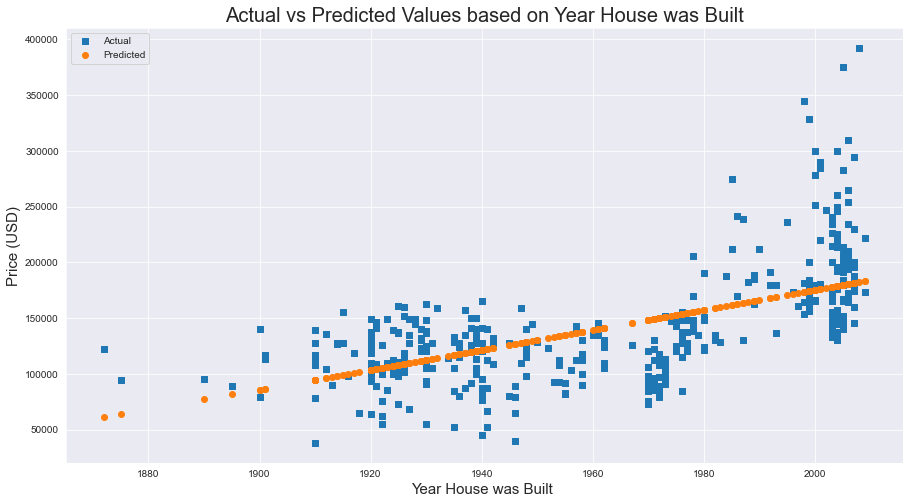

In [132]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)

ax1.scatter(housing['Year Built'], housing_dummied['SalePrice'],  marker="s", label='Actual')
ax1.scatter(housing['Year Built'], charting_preds,  marker="o", label='Predicted')
plt.legend(loc='upper left')
plt.title("Actual vs Predicted Values based on Year House was Built", size = 20)
plt.xlabel("Year House was Built ", size = 15)
plt.ylabel('Price (USD)', size = 15);
plt.show()

This map shows the relationship between the actual values and the predicted values for price based on the year the house was built. This chart shows a weaker correlation than the total square footage chart, but still shows a moderate linear relation. houses newer than the year 2000 seem to have a significantly harder time predicting the price with a linear model. 

# modeling

### 30% correlation model:
a model using all the numeric vairables with over .30 correlation with Sale Price

In [133]:
X = housing[thirty_corr]
y = housing['SalePrice']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 12)

In [135]:
basic_regression = LinearRegression()

In [136]:
cross_val_score(basic_regression,X_train,y_train).mean()

0.8493917513572503

In [137]:
basic_regression.fit(X_train,y_train)

LinearRegression()

In [138]:
basic_regression.score(X_train,y_train), basic_regression.score(X_test,y_test)

(0.8722337729040704, 0.8573880976717847)

These R2 scores are already much much better than our dummy model. This model is slightly overfit, as it performs much better on the train split than the test data. 

In [139]:
internal_testpreds = basic_regression.predict(X_test)

In [140]:
mean_squared_error(y_test,internal_testpreds, squared=False)

22538.36389632929

This RMSE value is also significantly higher than the dummy model. This model is already serving as an improved model that can be used to better predict the housing prices than the dummy model. Now I will try several more models to try and find ones that fit the data even better. 

''

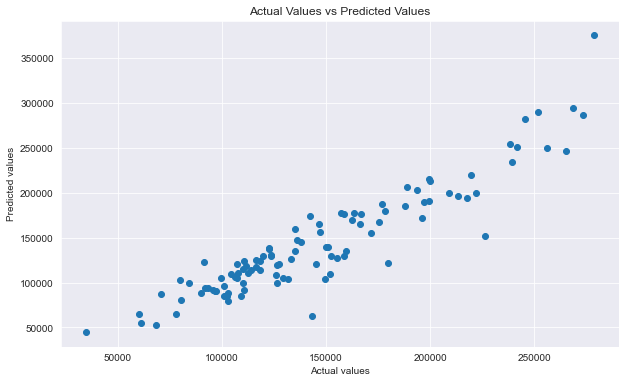

In [141]:
fig = plt.figure(figsize=(10,6))
plt.scatter(internal_testpreds, y_test)
plt.title('Actual Values vs Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
;

Plotting the predicted values vs the mean is a good way to visually evaulate the performance of a model. The close the model is to predicting as an exact straght line the better it is performing. This model is struggling with a few values, and hasa a relatively big spread, but it generally linear. 

kaggle submission:

In [142]:
testpreds = basic_regression.predict(housingtest[thirty_corr])

In [143]:
kaggle_submission = {
    'Id': test_ids,
    'SalePrice': testpreds
}

kaggle_submission = pd.DataFrame(kaggle_submission)

In [144]:
kaggle_submission.head()

,Id,SalePrice
0,2658,153577.638413
1,2718,197096.027253
2,2414,166413.273618
3,1989,104110.646670
4,625,177677.471998


In [145]:
kaggle_submission.to_csv('./kaggle_submissions/kaggle_submission_friday 2.csv', index=False)

Time to try the same model with the dummied version, adding in categorical columns as well. Dropped the Mas Vnr Type_other column from the train data because it wasn't in the test data, and it was already a bin of multiple types, and it didn't have the highest correlation scores. 

In [146]:
thirty_corr_dumm.remove('Mas Vnr Type_other')

In [147]:
X = housing_dummied[thirty_corr_dumm]
y = housing_dummied['SalePrice']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 12)

In [149]:
basic_regression = LinearRegression()

In [150]:
cross_val_score(basic_regression,X_train,y_train).mean()

0.8450451902593477

In [151]:
basic_regression.fit(X_train,y_train)

LinearRegression()

In [152]:
basic_regression.score(X_train,y_train), basic_regression.score(X_test,y_test)

(0.8801104726767028, 0.8651482000065327)

These R2 scores are pretty similar to the previous R2 scores, with a slight improvement. The two scores are getting closer together which is good, and they still have a pretty good fit for the model. 

In [153]:
internal_testpreds = basic_regression.predict(X_test)

In [154]:
mean_squared_error(y_test,internal_testpreds, squared=False)

21916.58448372291

This is also a slight improvement on the RMSE from the slightly more naive model, and still a massive improvement on the dummy model. Both of these models would make for pretty good models of the toal sale price. 

''

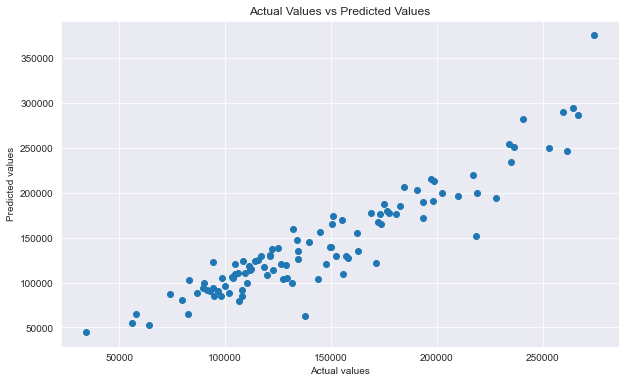

In [155]:
fig = plt.figure(figsize=(10,6))
plt.scatter(internal_testpreds, y_test)
plt.title('Actual Values vs Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
;

This graph shows an improvement in our model. The points are all much closer together and it forms a clear linear shape. There are still a few outliers but not as far out as before.

kaggle submission

In [156]:
testpreds = basic_regression.predict(housingtest_dummied[thirty_corr_dumm])

In [157]:
kaggle_submission = {
    'Id': test_ids,
    'SalePrice': testpreds
}

kaggle_submission = pd.DataFrame(kaggle_submission)

In [158]:
kaggle_submission.head()

,Id,SalePrice
0,2658,148728.469779
1,2718,196371.191463
2,2414,155078.578626
3,1989,103986.641119
4,625,183132.783838


In [159]:
kaggle_submission.to_csv('./kaggle_submissions/kaggle_submission_friday_2.csv', index=False)

Ridge method on 30% correlation dummied data. 

In [160]:
X = housing_dummied[thirty_corr_dumm]
y = housing_dummied['SalePrice']

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 12)

In [162]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [163]:
ridge = Ridge(alpha=10.0)

ridge.fit(Z_train,y_train)

Ridge(alpha=10.0)

In [164]:
ridge.score(Z_train,y_train), ridge.score(Z_test,y_test)

(0.879396376094733, 0.8658119348942126)

Use Ridge CV to try and determine the best value to use for alpha.

In [165]:
r_alphas = np.logspace(0,5,1000)
ridge_cv = RidgeCV(alphas=r_alphas, scoring= 'r2', cv=5)
ridge_cv.fit(Z_train,y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.01159111e+00, 1.02331658e+00, 1.03517796e+00,
       1.04717682e+00, 1.05931476e+00, 1.07159340e+00, 1.08401436e+00,
       1.09657929e+00, 1.10928986e+00, 1.12214777e+00, 1.13515471e+00,
       1.14831241e+00, 1.16162263e+00, 1.17508713e+00, 1.18870770e+00,
       1.20248614e+00, 1.21642429e+00, 1.23052400e+00, 1.24478715e+00,
       1.25921561e+00, 1.27381132e+0...
       7.67158118e+04, 7.76050334e+04, 7.85045620e+04, 7.94145172e+04,
       8.03350198e+04, 8.12661920e+04, 8.22081576e+04, 8.31610415e+04,
       8.41249705e+04, 8.51000725e+04, 8.60864770e+04, 8.70843150e+04,
       8.80937190e+04, 8.91148232e+04, 9.01477631e+04, 9.11926760e+04,
       9.22497005e+04, 9.33189772e+04, 9.44006479e+04, 9.54948564e+04,
       9.66017480e+04, 9.77214697e+04, 9.88541702e+04, 1.00000000e+05]),
        cv=5, scoring='r2')

In [166]:
ridge_cv.alpha_

51.48867450137495

In [167]:
ridge_cv.score(Z_train,y_train), ridge_cv.score(Z_test,y_test)

(0.87443244619757, 0.8635635529305529)

These scroes are very very slightly better than our first fit, using the alpha of 10. 

In [168]:
internal_testpreds = ridge_cv.predict(Z_test)

In [169]:
mean_squared_error(y_test,internal_testpreds, squared=False)

22044.979574418416

This RMSE is slightly worse than our normal linear model, although it is close. With more features to allow for ridge to determine what factors have the biggest impact on the model. 

''

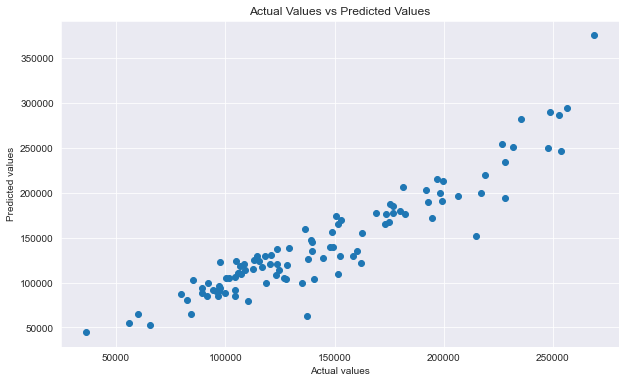

In [170]:
fig = plt.figure(figsize=(10,6))
plt.scatter(internal_testpreds, y_test)
plt.title('Actual Values vs Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
;

These data points are slightly more spread out than the previous model. The general linear structure of our predictions has been mostly kept, just the spread of the data around the line seems to change with the models. 

creating a new data frame to graphically look at the Ridge coefficients and make recommendations as to what features are impacting the model. (see extra graphs section) 

In [171]:
ridgedf = pd.DataFrame(list(zip(X.columns, ridge_cv.coef_)))

In [172]:
ridgedf.sort_values(1, ascending=False)

,0,1
2,Overall Qual,9116.998491
9,Gr Liv Area,6924.410762
6,BsmtFin SF 1,6733.964563
8,1st Flr SF,6132.043803
18,total_sf,6090.752273
1,Neighborhood,5147.064922
12,Fireplaces,4293.384090
20,MS Zoning_FV,4023.481517
16,Garage Area,3491.223934
7,Total Bsmt SF,3283.825436


After standardizing and looking at punishment, it seems we should run the model with only the most impactful correlations, meaning we want to keep values further away from zero. Will create a new list that can be used to do correlations on a new linear model to try and create the most efficient model. 

In [173]:
keepdf = ridgedf[(ridgedf[1] > 5000)| (ridgedf[1]< -1000)].copy()

In [174]:
keepdf

,0,1
0,Lot Shape,-2042.111094
1,Neighborhood,5147.064922
2,Overall Qual,9116.998491
6,BsmtFin SF 1,6733.964563
8,1st Flr SF,6132.043803
9,Gr Liv Area,6924.410762
15,Garage Cars,-2064.653154
18,total_sf,6090.752273
21,MS Zoning_RM,-1058.942425
24,Mas Vnr Type_None,-1304.845293


In [175]:
newlist = [x for x in keepdf[0]]

In [176]:
newlist

['Lot Shape',
 'Neighborhood',
 'Overall Qual',
 'BsmtFin SF 1',
 '1st Flr SF',
 'Gr Liv Area',
 'Garage Cars',
 'total_sf',
 'MS Zoning_RM',
 'Mas Vnr Type_None']

Linear model using the adjusted list from ridge:

In [177]:
newlist

['Lot Shape',
 'Neighborhood',
 'Overall Qual',
 'BsmtFin SF 1',
 '1st Flr SF',
 'Gr Liv Area',
 'Garage Cars',
 'total_sf',
 'MS Zoning_RM',
 'Mas Vnr Type_None']

In [178]:
X = housing_dummied[newlist]
y = housing_dummied['SalePrice']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 12)

In [180]:
basic_regression = LinearRegression()

In [181]:
cross_val_score(basic_regression,X_train,y_train).mean()

0.8373048279576313

In [182]:
basic_regression.fit(X_train,y_train)

LinearRegression()

In [183]:
basic_regression.score(X_train,y_train), basic_regression.score(X_test,y_test)

(0.85296487188055, 0.8244488251899609)

In [184]:
internal_testpreds = basic_regression.predict(X_test)

In [185]:
mean_squared_error(y_test,internal_testpreds, squared=False)

25006.1234071968

Unfortuantely, despite pruning the model performed the worst yet, perhaps indicating that the model is too simple, and Ridge cant perform as effectively as it wanted too with the small amount of features being used. 

In [186]:
testpreds =basic_regression.predict(housingtest_dummied[newlist])

''

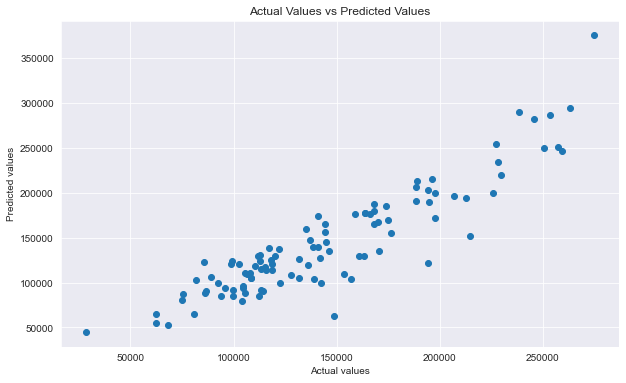

In [187]:
fig = plt.figure(figsize=(10,6))
plt.scatter(internal_testpreds, y_test)
plt.title('Actual Values vs Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
;

This is by far the worst of the models we have made besides the baseline. the data points are pretty spread out, and it has the least line-like shape of any of the models we have made so far.

Lasso method on 30% correlated columns that are polynomialized. 

In [188]:
X = housing_dummied[thirty_corr_dumm]
y = housing_dummied['SalePrice']

In [189]:
poly = PolynomialFeatures(include_bias=False)

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 12)

In [191]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [192]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train_poly)
Z_test = sc.transform(X_test_poly)

In [193]:
l_alphas = np.logspace(-3,0,100)

lasso_cv = LassoCV(alphas=l_alphas,cv=5)

lasso_cv.fit(Z_train,y_train)

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8278652668.69005, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7125624795.846079, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6594456489.090547, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5541040242.072369, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5584668758.258665, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5591417590.449027, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6394967416.0113735, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6408750419.993288, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6422208090.285402, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linea

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6549429412.217337, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6549265836.238412, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6548932584.330234, tolerance: 63431686.70723919
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 936140985.506845, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 899937991.6749122, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 859985162.4106585, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 437164773.4312952, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429288972.9131576, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421727675.5155331, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307057900.7083397, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304693815.4956151, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302422679.76464695, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linea

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265308811.96410128, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264429210.11908996, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263575071.06995603, tolerance: 54081865.59743102
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\lin

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5682452785.110666, tolerance: 65836856.977909364
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5699834039.654797, tolerance: 65836856.977909364
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5723336206.039408, tolerance: 65836856.977909364
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\lin

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6486452069.348782, tolerance: 65836856.977909364
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6497689246.082815, tolerance: 65836856.977909364
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6507832078.487824, tolerance: 65836856.977909364
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\lin

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6595118272.823275, tolerance: 65836856.977909364
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6594483321.505364, tolerance: 65836856.977909364
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6593707243.334766, tolerance: 65836856.977909364
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\lin

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5510275946.742463, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5400832245.086563, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5326624681.059625, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6212585258.304839, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6234081060.752471, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6257482155.319099, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6532214309.7315035, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6535901301.777639, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6539050590.029213, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linea

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6542771302.969337, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6541024890.08915, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6539217472.918248, tolerance: 59898258.89075936
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 713841201.8288343, tolerance: 61913487.79326342
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 677610205.6381565, tolerance: 61913487.79326342
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 644809369.3484714, tolerance: 61913487.79326342
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229465998.83042192, tolerance: 61913487.79326342
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833959.2891209, tolerance: 61913487.79326342
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216541576.4934067, tolerance: 61913487.79326342
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linea

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127107874.31745695, tolerance: 61913487.79326342
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125391208.04102519, tolerance: 61913487.79326342
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123747368.16118023, tolerance: 61913487.79326342
  model = cd_fast.enet_coordinate_descent(
C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\lin

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
        cv=5)

This data set might not be the best to do lasso on, as it has a lot of convergence issues, but still seems to be able to generate some alpha values and figure out the ideal alpha.

In [194]:
lasso_cv.alpha_

1.0

In [195]:
print(f"Training LASSO R-Squared: {lasso_cv.score(Z_train, y_train)}")
print(f"Testing LASSO R-Squared: {lasso_cv.score(Z_test, y_test)}")

Training LASSO R-Squared: 0.9713654050891913
Testing LASSO R-Squared: 0.6983973059646806


These are our highest R squared values so far, but there some clear overfitting going on, so if we wanted to improve on the model we would want to remove the features with a weak correlation from the model.  

In [196]:
internal_testpreds4 = lasso_cv.predict(Z_test)

In [197]:
mean_squared_error(y_test,internal_testpreds4, squared=False)

32776.46469570319

''

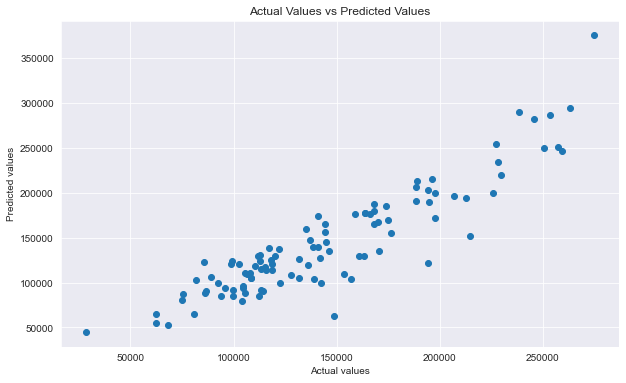

In [198]:
fig = plt.figure(figsize=(10,6))
plt.scatter(internal_testpreds, y_test)
plt.title('Actual Values vs Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
;

This is also a poor performing model. It has a better line-like structure than the previous model but it is still very spread. I plan on using the lasso coefficients to try and create a model with less noise. 

In [199]:
lassodf = pd.DataFrame(list(zip(X.columns, lasso_cv.coef_)))

In [200]:
lassodf.sort_values(1, ascending=False).head()

,0,1
1,Neighborhood,20511.334587
24,Mas Vnr Type_None,13963.538453
6,BsmtFin SF 1,13035.644105
17,Paved Drive,10132.028931
14,Garage Finish,9805.189914


after standardizing and looking at punishment, it seems we should run the model with only the most impactful correlations, meaning we want to keep values further away from zero. Will create a new list that can be used to do correlations on a new linear model to try and create the most efficient model. 

In [201]:
lasso_keepdf = lassodf[(lassodf[1] > 5000)| (lassodf[1]< -1000)].copy()

In [202]:
lasso_keepdf.head()

,0,1
0,Lot Shape,-14244.255355
1,Neighborhood,20511.334587
2,Overall Qual,7918.837720
3,Year Built,-7941.180501
5,BsmtFin Type 1,5339.957958


In [203]:
newlist2 = [x for x in lasso_keepdf[0]]

In [204]:
newlist2

['Lot Shape',
 'Neighborhood',
 'Overall Qual',
 'Year Built',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 '1st Flr SF',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Area',
 'Paved Drive',
 'total_sf',
 'MS Zoning_FV',
 'MS Zoning_RM',
 'Bldg Type_TwnhsE',
 'Mas Vnr Type_None',
 'Central Air_Y']

The last model:

In [205]:
X = housing_dummied[newlist2]
y = housing_dummied['SalePrice']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 12)

In [207]:
basic_regression = LinearRegression()

In [208]:
cross_val_score(basic_regression,X_train,y_train).mean()

0.8433651827784463

In [209]:
basic_regression.fit(X_train,y_train)

LinearRegression()

In [210]:
basic_regression.score(X_train,y_train), basic_regression.score(X_test,y_test)

(0.8705131877295553, 0.8639395210016633)

These R2 scores are pretty good and we have solved our over-fitting problem from the lasso model by removing the features that weren't helping. This model seems to be a good possible option for predicting the housing prices.

In [211]:
internal_testpreds = basic_regression.predict(X_test)

In [212]:
mean_squared_error(y_test,internal_testpreds, squared=False)

22014.584741104056

This is not our best RMSE that we have seen, but it is in the ballpark of all of our other RMSE scores and has a good R2 score. Given the data that we have worked with this seems like it could be a suitable model for predicting the housing prices in Ames, Iowa.  

''

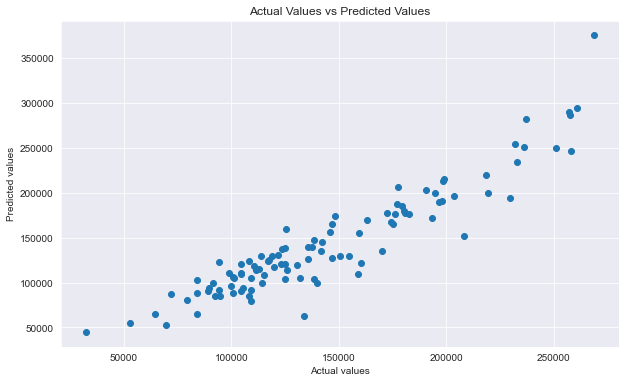

In [213]:
fig = plt.figure(figsize=(10,6))
plt.scatter(internal_testpreds, y_test)
plt.title('Actual Values vs Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
;

This is definitely our most line-like graph. The points are relatively packed together and the line shape is very clear. There is really only one outlier prediction which is struggling a lot compared to the rest. 

kaggle submission:

In [221]:
testpreds = basic_regression.predict(housingtest_dummied[newlist2])

In [222]:
kaggle_submission = {
    'Id': test_ids,
    'SalePrice': testpreds
}

kaggle_submission = pd.DataFrame(kaggle_submission)

In [223]:
kaggle_submission.head()

,Id,SalePrice
0,2658,140131.622270
1,2718,197003.277398
2,2414,150133.716454
3,1989,110760.441042
4,625,185672.010955


In [224]:
kaggle_submission.to_csv('./kaggle_submissions/kaggle_submission_friday_3.csv', index=False)

# conclusion

Using several models it is possible to assess the home value of all the homes Ben Seller finds himself suddenly in control of:

1. The overall size of the house is a big determining factor in the price, and the age also has a moderate influence.

2. Factors such as the neighborhood the house is in, the number of fireplaces, and whether or not the house has central air can play a key role in determining house prices.

3. One of the most important features is the overall quality of the house.

This project recommends the following going forward to Mr. Seller:

1. Evaluate the size and location of all of your newly acquired houses to get an estimate of the house's value.

2. With more data an effective model can be built to more accurately predict the price of the houses you are trying to sell.

Evaluating the strength of our model, It is clear that is still room for improvement. Using a different slurry of features and testing other feature combinations could always result in a stronger model. The model also does not seem to be well tuned to dealing with outliers, as the train data which was cleared of outliers almost always outperforms the validation data. Stronger feature engineering could also result in a more robust final model created. Overall though the final model has a R2 score of .86 with a RMSE of 22,000. This model would work as a groundwork model to pave the way for more robust models. 


# extra visualizations:

In [214]:
ridgedf.head()

,0,1
0,Lot Shape,-2042.111094
1,Neighborhood,5147.064922
2,Overall Qual,9116.998491
3,Year Built,670.331072
4,Year Remod/Add,2139.167008


In [215]:
renamedict = {
    'Lot Shape': 'Lot Shape', 'Neighborhood':'Neighborhood', 'Overall Qual': 'Overall Quality', 
    'Year Built': 'Year Built', 'Year Remod/Add': 'Remodeled', 'BsmtFin Type 1': 'Finished Basement',
    'BsmntFin SF 1': 'Size of Finshed Basement', 'Bsmt Full Bath': 'Full Baths Basement',
    'Total Bsmt SF': 'Total basement size (finshed + unfished)', '1st Flr SF': 'First Floor Size',
    'Gr Liv Area': 'Above ground living area', 'Full Bath': 'Full Bath Total', 'Fireplaces': 'Number of Fireplaces',
    'Garage Yr Blt': 'Year Garage Built', 'Garage Finish': 'Interior Status of Gararage',
    'Garage Cars': 'Garage Cars', 'Garage Area': 'Garage Area', 'Paved Drive': 'Paved Driveway',
    'total_sf':'Total Square Footage', 'recently built': 'built after 2000', 
    'Ms Zoning_FV': 'Floating Village', 'MS Zoning_RM': 'Residental density (medium)',
    'Bldg Type_TwnhsE': 'Townhouse', 'House Style_1Story': 'Single Story House',
    'Mas Vnr Type_None': 'No Masonry Veneer', 'Foundation_Cblock': 'Cinder Block Foundation',
    'Foundation_PConc' : 'Poured Concrete Foundation', 'Central Air_Y': 'Has Central Air'

}

In [216]:
ridgedf[0] = ridgedf[0].map(renamedict)

In [217]:
ridgedf

,0,1
0,Lot Shape,-2042.111094
1,Neighborhood,5147.064922
2,Overall Quality,9116.998491
3,Year Built,670.331072
4,Remodeled,2139.167008
5,Finished Basement,1639.539992
6,NaN,6733.964563
7,Total basement size (finshed + unfished),3283.825436
8,First Floor Size,6132.043803
9,Above ground living area,6924.410762


In [218]:
ridgedf.rename(columns={0 : 'Feature', 1: 'Ridge Coefs'}, inplace=True)

In [219]:
ridgedf = ridgedf.sort_values('Ridge Coefs', ascending=False).reset_index(drop=True)

''

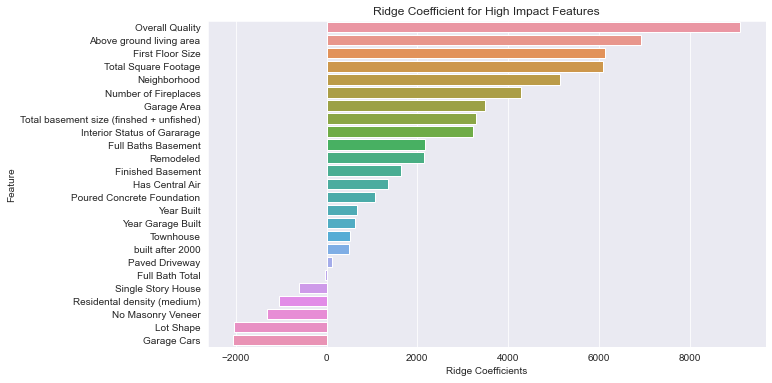

In [220]:
plt.figure(figsize=(10,6))
 
ax = sns.barplot(x= 'Ridge Coefs',
                 y= 'Feature',
                 data= ridgedf,
                 ci= False,
           )
plt.title('Ridge Coefficient for High Impact Features')
plt.xlabel('Ridge Coefficients')
;